# LS-Gan (Least Square Gan)

This is an attempt to re-implement the paper LS-GAN

Paper: https://arxiv.org/pdf/1611.04076v3.pdf

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
img_size = 112
channels = 3
batch_size = 64
num_images = 1000
path = 'E://Image Datasets//Celeb A//Dataset//img_align_celeba//img_align_celeba//*.jpg'

In [3]:
def load_file(file):
    images = tf.io.decode_png(tf.io.read_file(file), channels = channels)

    images = tf.cast(images, tf.float32)
    images = tf.image.resize(images, [img_size, img_size], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    images = (images/127.5) - 1
    
    return images

def load_data(path, num_images = num_images):
    data = glob(path)[:num_images]
    return tf.data.Dataset.list_files(data).map(load_file).shuffle(len(data)).batch(batch_size)

dataset = load_data(path)
dataset

<BatchDataset shapes: (None, 112, 112, 3), types: tf.float32>

In [4]:
class GAN(object):
    def __init__(self, latent_dim = 1024):
        self.latent_dim = latent_dim
        self.img_shape = self.generator.output_shape[1:]
        
    @property
    def generator(self):
        inp = tf.keras.layers.Input(shape = (self.latent_dim, ), dtype = tf.float32, 
                                    name = f'generator_latent_input_{self.latent_dim}')
        
        x = tf.keras.layers.Dense(units = 7*7*256)(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Reshape((7, 7, 256))(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
        x = tf.keras.layers.Activation('tanh')(x)
        
        return tf.keras.models.Model(inp, x, name = 'generator')

    @property
    def discriminator(self):
        
        inp = tf.keras.layers.Input(shape = self.img_shape, dtype = tf.float32, 
                                name = f'discriminator_input_{self.img_shape[0]}x{self.img_shape[1]}x{self.img_shape[2]}')
        
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 512, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units = 1)(x)
        
        return tf.keras.models.Model(inp, x, name = 'generator')

In [5]:
class Trainer(object):
    def __init__(self, learning_rate = 2e-4, latent_dim = 1024):
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5)
        
        self.latent_dim = latent_dim
        
        gan = GAN(latent_dim = latent_dim)
        self.generator = gan.generator
        self.discriminator = gan.discriminator
        
    def generate_noise(self, batch_size):
        return tf.random.normal((batch_size, self.latent_dim), mean = 0.0, stddev = 1.0)
    
    def discriminator_loss(self, disc_real_out, disc_gen_out):
        real_loss = tf.math.reduce_mean(tf.math.square(tf.ones_like(disc_real_out) - disc_real_out))
        gen_loss = tf.math.reduce_mean(tf.math.square(tf.zeros_like(disc_gen_out) - disc_gen_out))
        return 0.5 * (real_loss + gen_loss)
    
    def generator_loss(self, disc_gen_out):
        return tf.math.reduce_mean(tf.math.square(tf.ones_like(disc_gen_out) - disc_gen_out))
        
    @tf.function
    def train_step(self, real_img):
        noise = self.generate_noise(real_img.shape[0])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_out = self.generator(noise, training = True)
            
            disc_real_out = self.discriminator(real_img, training = True)
            disc_gen_out = self.discriminator(gen_out, training = True)
            
            disc_loss = self.discriminator_loss(disc_real_out, disc_gen_out)
            gen_loss = self.generator_loss(disc_gen_out)
            
        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        
        return gen_loss, disc_loss
    
    def train(self, data, epochs = 1):
        gen_losses, disc_losses = [], []
        for e in range(epochs):
            print(f'Epoch: {e} Starts')
            for img in data:
                gen_loss, disc_loss = self.train_step(img)
                print('.', end = '')
               
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)
            print(f'\nGenerator Loss: {gen_loss} \t Discriminator Loss: {disc_loss}')
            print(f'Epoch: {e} Ends\n')
            
        return {'gen_losses': gen_losses, 'disc_losses': disc_losses}

In [6]:
trainer = Trainer()

In [29]:
training_losses = trainer.train(dataset, epochs = 20)

Epoch: 0 Starts
................
Generator Loss: 0.3448457717895508 	 Discriminator Loss: 0.15923650562763214
Epoch: 0 Ends

Epoch: 1 Starts
................
Generator Loss: 0.8425217866897583 	 Discriminator Loss: 0.06128590926527977
Epoch: 1 Ends

Epoch: 2 Starts
................
Generator Loss: 0.685559093952179 	 Discriminator Loss: 0.06536118686199188
Epoch: 2 Ends

Epoch: 3 Starts
................
Generator Loss: 0.983515739440918 	 Discriminator Loss: 0.05764124542474747
Epoch: 3 Ends

Epoch: 4 Starts
................
Generator Loss: 0.8561742901802063 	 Discriminator Loss: 0.07689762860536575
Epoch: 4 Ends

Epoch: 5 Starts
................
Generator Loss: 0.8006652593612671 	 Discriminator Loss: 0.04933324083685875
Epoch: 5 Ends

Epoch: 6 Starts
................
Generator Loss: 1.0098663568496704 	 Discriminator Loss: 0.06771019846200943
Epoch: 6 Ends

Epoch: 7 Starts
................
Generator Loss: 1.0128153562545776 	 Discriminator Loss: 0.07753534615039825
Epoch: 7 Ends

Ep

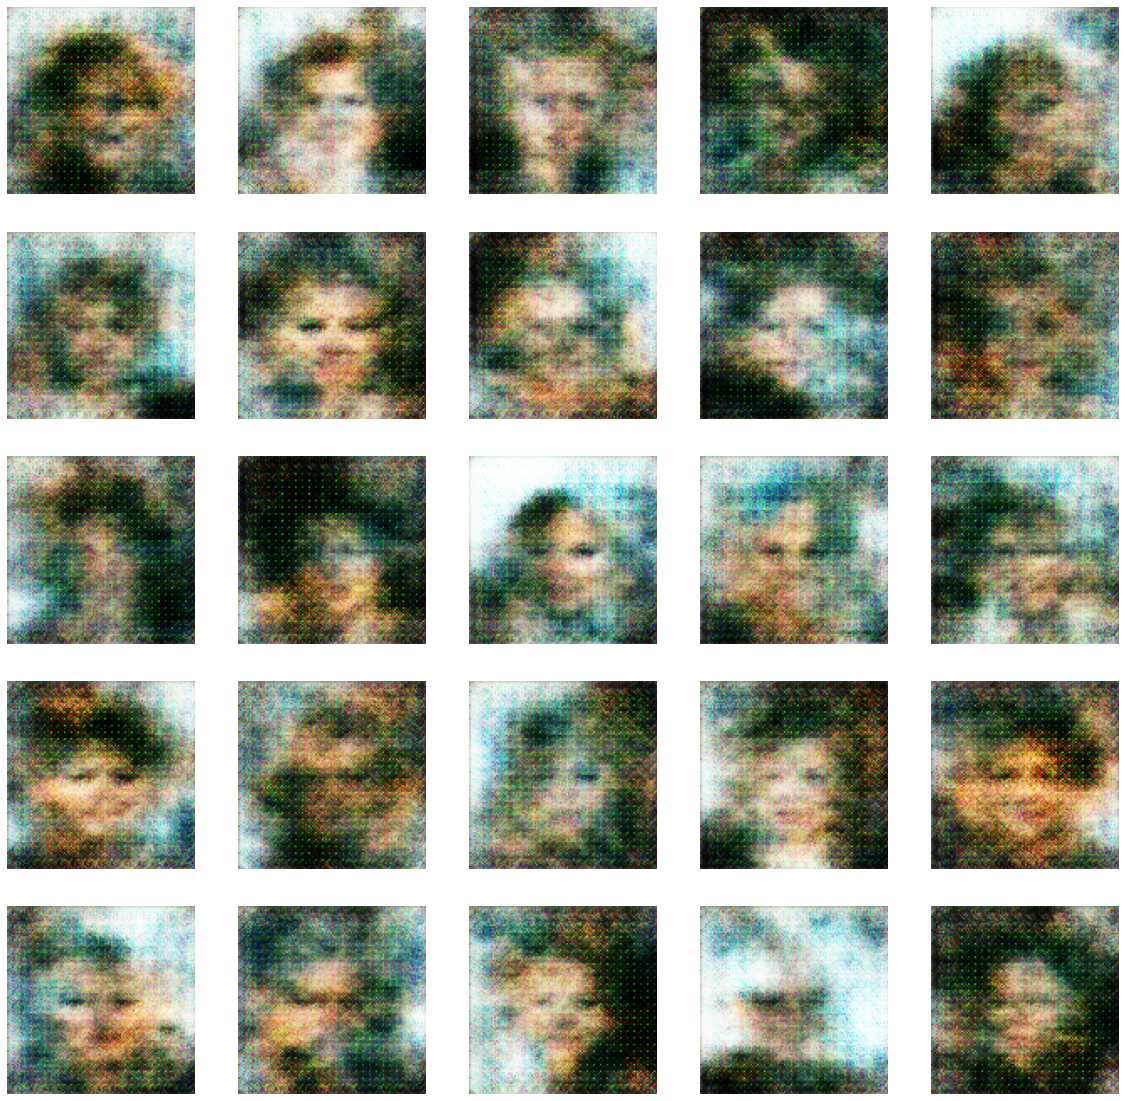

In [30]:
noise = tf.random.normal((25, 1024))
gen_img = ((trainer.generator(noise)+1)*127.5).numpy().astype('uint8')

plt.figure(figsize = (20, 20))
for i in range(noise.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(gen_img[i])
    plt.axis('off')
    
plt.show()

In [32]:
plt.plot(training_losses['gen_losses'], label = 'gen losses')
plt.plot(training_losses['disc_losses'], label = 'disc losses')
plt.show()